# 06 — Temporal validation (rolling-origin backtest)

## Objective
Evaluate out-of-sample performance of the MMM using time-aware splits.

## Model under evaluation
- Features: adstock + saturation (baseline theta, baseline alpha, k by channel)
- Estimator: Ridge regression (with feature scaling)

## Output
- Rolling-origin backtest metrics (R², MAE)
- Coefficient stability across folds
- Diagnostics to assess robustness


## Why time-aware validation

Random train/test splits leak future information and break temporal structure.

### Decision
Use rolling-origin (walk-forward) validation:
- train on an expanding window
- test on the next fixed horizon

### Rationale
MMM is used for decisions over future periods. We must evaluate generalization
to unseen future weeks.


In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error


In [19]:
X_sat = pd.read_csv("../data/processed/mmm_dataset_weekly_saturation.csv")
y = pd.read_csv("../data/processed/mmm_dataset_weekly_y_column.csv")
# df_mmm = pd.read_csv("../data/processed/mmm_dataset_weekly_adstock.csv")
df_mmm = pd.read_csv("../data/processed/mmm_dataset_weekly.csv")
spend_cols = [c for c in df_mmm.columns if c.endswith("_SPEND")]

In [3]:
dates = pd.to_datetime(df_mmm["week"]).values

X = X_sat.copy()               # final features from notebook 04/05
y_1d = np.asarray(y).ravel()   # ensure 1D

# sort by time
order = np.argsort(dates)
dates = dates[order]
X = X.iloc[order].reset_index(drop=True)
y_1d = y_1d[order]

X.shape, y_1d.shape, dates.min(), dates.max()


((251, 9),
 (251,),
 np.datetime64('2019-08-12T00:00:00.000000000'),
 np.datetime64('2024-05-27T00:00:00.000000000'))

## Rolling-origin setup

We define:
- `min_train_weeks`: minimum training history for the first model
- `test_weeks`: length of each test window (forecast horizon)
- `step_weeks`: how far we move forward between folds

Baseline configuration:
- min_train_weeks = 104  (≈ 2 years)
- test_weeks = 26        (≈ 6 months)
- step_weeks = 26


In [4]:
def rolling_origin_splits(n, min_train_weeks=104, test_weeks=26, step_weeks=26):
    splits = []
    train_end = min_train_weeks

    while train_end + test_weeks <= n:
        train_idx = np.arange(0, train_end)
        test_idx = np.arange(train_end, train_end + test_weeks)
        splits.append((train_idx, test_idx))
        train_end += step_weeks

    return splits

splits = rolling_origin_splits(len(X), min_train_weeks=104, test_weeks=26, step_weeks=26)
len(splits), [(len(tr), len(te)) for tr, te in splits[:3]]


(5, [(104, 26), (130, 26), (156, 26)])

In [5]:
ridge_alpha = 1.0

rows = []
coef_folds = []

for i, (tr, te) in enumerate(splits, start=1):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=ridge_alpha))
    ])

    model.fit(X.iloc[tr], y_1d[tr])
    pred = model.predict(X.iloc[te])

    rows.append({
        "fold": i,
        "train_start": pd.to_datetime(dates[tr][0]).date(),
        "train_end": pd.to_datetime(dates[tr][-1]).date(),
        "test_start": pd.to_datetime(dates[te][0]).date(),
        "test_end": pd.to_datetime(dates[te][-1]).date(),
        "r2_test": r2_score(y_1d[te], pred),
        "mae_test": mean_absolute_error(y_1d[te], pred),
    })

    coef = model.named_steps["ridge"].coef_
    coef_folds.append(pd.Series(coef, index=X.columns, name=f"fold_{i}"))

results = pd.DataFrame(rows)
coef_folds_df = pd.DataFrame(coef_folds)

results


,fold,train_start,train_end,test_start,test_end,r2_test,mae_test
0,1,2019-08-12,2021-08-02,2021-08-09,2022-01-31,-0.015331,17.860836
1,2,2019-08-12,2022-01-31,2022-02-07,2022-08-01,-0.865488,30.849599
2,3,2019-08-12,2022-08-01,2022-08-08,2023-01-30,-67.705544,247.725736
3,4,2019-08-12,2023-01-30,2023-02-06,2023-07-31,-14.456530,114.631897
4,5,2019-08-12,2023-07-31,2023-08-07,2024-01-29,-0.065795,19.113383


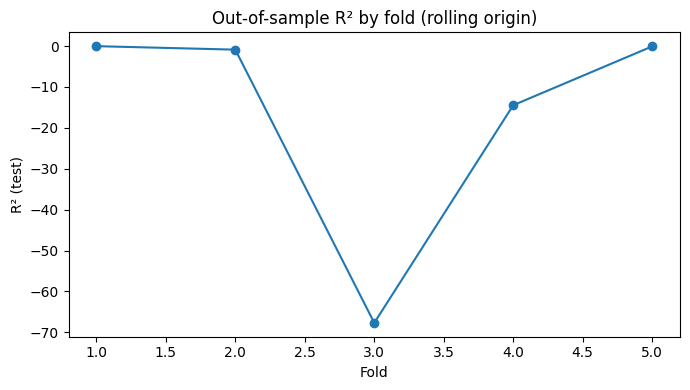

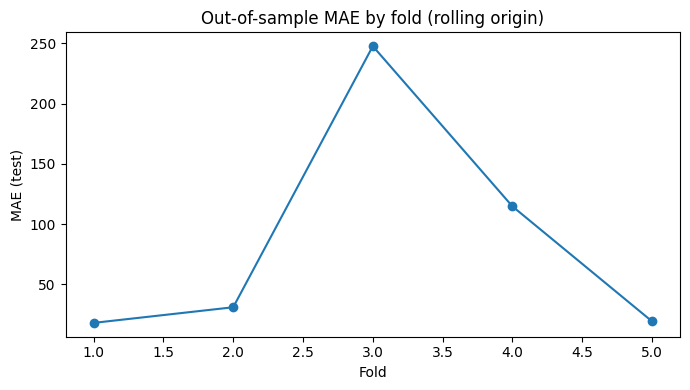

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(results["fold"], results["r2_test"], marker="o")
plt.xlabel("Fold")
plt.ylabel("R² (test)")
plt.title("Out-of-sample R² by fold (rolling origin)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(results["fold"], results["mae_test"], marker="o")
plt.xlabel("Fold")
plt.ylabel("MAE (test)")
plt.title("Out-of-sample MAE by fold (rolling origin)")
plt.tight_layout()
plt.show()


coef_summary = pd.DataFrame({
    "mean": coef_folds_df.mean(),
    "std": coef_folds_df.std(),
    "cv": coef_folds_df.std() / (coef_folds_df.mean().abs() + 1e-8),
}).sort_values("cv")

coef_summary


## Interpretation checklist

We look for:
- reasonably stable test metrics across folds (no collapse in later folds)
- consistent coefficient signs for key channels
- no extreme coefficient volatility across folds

If performance is unstable:
- revisit feature definitions (theta, alpha, k)
- adjust ridge_alpha
- consider adding controls (trend/seasonality)
- shorten/segment the modeling window


## Interpretation and limitations

Out-of-sample performance varies substantially across time periods.
In particular, the model fails to generalize during mid-2022 to early-2023,
suggesting a structural break in the data generating process.

This behavior is expected in MMM settings where:
- marketing response functions are assumed stable
- external shocks (pricing, macroeconomic changes, demand shifts) are not modeled

Despite limited predictive accuracy in some folds, coefficient analysis reveals
that certain channels (e.g. Shopping) exhibit stable contributions, while others
are highly sensitive to the time window.

As a result, this model is better suited for structural analysis and strategic
budget reasoning than for short-term forecasting.


## 06B — Add time controls (trend + seasonality)

### Goal
Separate baseline business dynamics (trend/seasonality) from incremental marketing effects,
to improve temporal generalization and reduce misattribution.


## Formulación del Marketing Mix Model

El modelo final implementado en este proyecto puede expresarse como:

$y_t =
\underbrace{\beta_0}_{\text{intercepto}}
+
\underbrace{\beta_{trend} \cdot t}_{\text{tendencia}}
+
\underbrace{\sum_{k=1}^{K} \left(
\beta_{s_k} \sin\left(\frac{2\pi k t}{P}\right)
+
\beta_{c_k} \cos\left(\frac{2\pi k t}{P}\right)
\right)}_{\text{estacionalidad}}
+
\underbrace{\sum_{i=1}^{N} \beta_i \cdot f_i(x_{i,t})}_{\text{contribución marketing}}
+
\varepsilon_t$

Cada término corresponde a una decisión metodológica introducida progresivamente.

---

### 1. Variable objetivo (KPI)

$y_t$

- Métrica de negocio observada en el tiempo $t$.
- Agregada semanalmente.

---

### 2. Tendencia (baseline del negocio)

$\beta_{trend} \cdot t$

- Captura cambios estructurales de largo plazo.
- Modela crecimiento o declive orgánico.
- Evita que el marketing absorba efectos puramente temporales.

---

### 3. Estacionalidad

$\sum_{k=1}^{K} \left(
\beta_{s_k} \sin\left(\frac{2\pi k t}{P}\right)
+
\beta_{c_k} \cos\left(\frac{2\pi k t}{P}\right)
\right)$

- Modela patrones periódicos recurrentes (ej. anual).
- Se implementa mediante términos de Fourier.
- $P = 52$ semanas, $K$ controla la flexibilidad.

---

### 4. Contribución de marketing

Para cada canal $i$:

#### 4.1 Adstock (efecto arrastre)

$\tilde{x}_{i,t} = x_{i,t} + \theta \cdot \tilde{x}_{i,t-1}$

- Modela efectos retardados de la publicidad.
- $\theta$ controla la persistencia del impacto.

---

#### 4.2 Saturación (retornos decrecientes)

$f_i(x_{i,t}) =
\frac{\tilde{x}_{i,t}^{\alpha}}{\tilde{x}_{i,t}^{\alpha} + k_i^{\alpha}}$

- Captura retornos marginales decrecientes.
- $k_i$: nivel de gasto donde se alcanza el 50% del efecto máximo.
- $\alpha$: pendiente de la curva.

---

#### 4.3 Contribución lineal

$\beta_i \cdot f_i(x_{i,t})$

- Los inputs transformados entran linealmente al modelo.
- Los coeficientes representan contribuciones incrementales.

---

### 5. Regularización (Ridge)

Los coeficientes se estiman resolviendo:

$\min_{\beta}
\left\|
y - X\beta
\right\|^2
+
\lambda \left\|
\beta
\right\|^2$

- Reduce inestabilidad por multicolinealidad.
- Evita coeficientes extremos.
- Mejora robustez temporal.

---

### 6. Término de error

$\varepsilon_t$

- Captura ruido, shocks y variables no observadas.

---

### Interpretación final

Este modelo separa explícitamente:

- **Baseline del negocio** (tendencia + estacionalidad)
- **Efectos incrementales del marketing**
- **Ruido**

Está diseñado para **interpretación estratégica y análisis de escenarios**, no para forecasting operativo.


## Tendencia y Estacionalidad en Marketing Mix Modeling

### Motivación

En negocios reales, la métrica objetivo (ventas, conversiones, ingresos) cambia en el tiempo
aunque no exista inversión en marketing.

Si estas dinámicas de base no se modelan explícitamente, el MMM acaba atribuyendo efectos
temporales al marketing, produciendo coeficientes sesgados y mala generalización temporal.

Por ello, la tendencia y la estacionalidad se introducen como **controles de baseline**.

---

## 1. Tendencia

### Definición conceptual

La **tendencia** representa cambios estructurales de largo plazo en el negocio que evolucionan
de forma gradual y no son causados directamente por el gasto en marketing.

Ejemplos habituales:
- Crecimiento o declive orgánico
- Madurez de marca
- Expansión o saturación del mercado
- Cambios de pricing
- Evolución del catálogo de productos

---

### Formulación matemática

La forma más simple es una tendencia lineal:

$
\text{tendencia}_t = \beta_{trend} \cdot t
$

Donde:
- $t$ es un índice temporal
- $\beta_{trend}$ mide el crecimiento (o caída) semanal promedio

---

### Por qué es necesaria la tendencia

Sin un término de tendencia:
- El crecimiento sostenido se atribuye al marketing
- Los coeficientes se inflan artificialmente
- El rendimiento out-of-sample empeora

La tendencia permite separar crecimiento orgánico de efectos incrementales.

---

## 2. Estacionalidad

### Definición conceptual

La **estacionalidad** captura patrones recurrentes que se repiten periódicamente en el tiempo.

Ejemplos:
- Campañas navideñas
- Rebajas
- Ciclos anuales de demanda
- Comportamientos habituales del consumidor

Es predecible y no depende del marketing.

---

### Formulación matemática (Fourier)

Se modela mediante funciones seno y coseno:

$
\text{estacionalidad}_t =
\sum_{k=1}^{K}
\left[
\beta_{s_k} \sin\left(\frac{2\pi k t}{P}\right)
+
\beta_{c_k} \cos\left(\frac{2\pi k t}{P}\right)
\right]
$

Donde:
- $P = 52$ semanas
- $K$ controla la flexibilidad del patrón estacional

---

### Ventajas frente a dummies

- Transiciones suaves
- Menos parámetros
- Mejor extrapolación
- Menor sobreajuste

---

## 3. Relación con variables de marketing

El gasto en marketing suele concentrarse en periodos estacionales.
Sin controles explícitos, el modelo confunde correlación con causalidad.

La estacionalidad:
- estabiliza coeficientes
- mejora atribución
- reduce sesgo

---

## 4. Impacto en validación temporal

Incluir tendencia y estacionalidad:
- mejora la robustez temporal
- reduce colapsos en ciertos folds
- separa baseline y efecto incremental

---

## Idea clave

> Tendencia y estacionalidad aíslan la dinámica base del negocio,
> permitiendo interpretar el marketing como impacto incremental real.


In [7]:
df_weekly = pd.read_csv("../data/processed/mmm_dataset_weekly.csv")
df_ads = pd.read_csv("../data/processed/mmm_dataset_weekly_saturation.csv")

# Aseguramos datetime y orden
df_weekly["week"] = pd.to_datetime(df_weekly["week"])
df_weekly = df_weekly.sort_values("week").reset_index(drop=True)
df_ads = df_ads.reset_index(drop=True)

# Añadimos week al dataframe adstock
df_ads_with_week = pd.concat(
    [df_weekly[["week"]], df_ads],
    axis=1
)

df_mmm_weekly = df_ads_with_week

In [8]:
import numpy as np
import pandas as pd

n = len(df_mmm_weekly)
df_mmm_weekly = df_mmm_weekly.sort_values("week").reset_index(drop=True)

df_mmm_weekly["trend_t"] = np.arange(n, dtype=float)

woy = df_mmm_weekly["week"].dt.isocalendar().week.astype(int).to_numpy()
P = 52
K = 2  # seasonality_order

for k in range(1, K+1):
    df_mmm_weekly[f"sin_{P}_k{k}"] = np.sin(2*np.pi*k*woy/P)
    df_mmm_weekly[f"cos_{P}_k{k}"] = np.cos(2*np.pi*k*woy/P)


In [9]:
from ma_mmm_package.pipelines.run_mmm import backtest_time_series, MMMConfig

cfg = MMMConfig(
    target_col="ALL_PURCHASES",
    theta=0.5,
    sat_alpha=1.0,
    ridge_alpha=1.0,
    add_trend=True,
    add_seasonality=True,
)


In [10]:
time_cols = ["trend_t"] + [f"sin_52_k{k}" for k in range(1, K+1)] + [f"cos_52_k{k}" for k in range(1, K+1)]
X_time = df_mmm_weekly[time_cols]

X_with_time = pd.concat([X_time.reset_index(drop=True), X_sat.reset_index(drop=True)], axis=1)

results_time, coef_folds_time = backtest_time_series(X_with_time, y_1d, dates, cfg)
results_time


,fold,train_start,train_end,test_start,test_end,r2_test,mae_test
0,1,2019-08-12,2021-08-02,2021-08-09,2022-01-31,-3.868744,42.489186
1,2,2019-08-12,2022-01-31,2022-02-07,2022-08-01,0.231507,21.017196
2,3,2019-08-12,2022-08-01,2022-08-08,2023-01-30,-23.620964,149.358131
3,4,2019-08-12,2023-01-30,2023-02-06,2023-07-31,-2.347057,50.854539
4,5,2019-08-12,2023-07-31,2023-08-07,2024-01-29,-2.491273,41.691098


In [11]:
coef_folds_time

,trend_t,sin_52_k1,sin_52_k2,cos_52_k1,cos_52_k2,GOOGLE_PAID_SEARCH_SPEND,GOOGLE_SHOPPING_SPEND,GOOGLE_PMAX_SPEND,GOOGLE_DISPLAY_SPEND,GOOGLE_VIDEO_SPEND,META_FACEBOOK_SPEND,META_INSTAGRAM_SPEND,META_OTHER_SPEND,TIKTOK_SPEND
fold_1,30.944600,12.215146,-0.802197,1.664521,-7.062469,3.540180,16.440511,0.000000,1.233020,0.0,0.0,0.0,0.0,0.0
fold_2,19.216938,13.722982,-1.593429,-0.102568,-6.118900,11.005376,23.323135,0.000000,0.400257,0.0,0.0,0.0,0.0,0.0
fold_3,22.768000,14.104428,0.932166,2.467460,-7.585582,11.488290,23.588586,-2.833839,0.135829,0.0,0.0,0.0,0.0,0.0
fold_4,29.485192,15.472198,1.617641,4.190835,-7.111592,15.410559,20.723999,18.174133,-0.329241,0.0,0.0,0.0,0.0,0.0
fold_5,49.176238,17.550296,3.467407,3.325461,-7.592634,18.413274,9.895864,14.816284,-0.039321,0.0,0.0,0.0,0.0,0.0


## 06C — Interpret time controls (raw coefficients + reconstructed seasonality)

> Note: coefficients from the Ridge model inside a `StandardScaler` pipeline are **in standardized feature space**.
> For interpretation in KPI units, we back-transform coefficients to the original feature scale.



In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

def fit_one_model_return_raw_betas(X, y, ridge_alpha=1.0):
    """Fit a scaled Ridge model and back-transform coefficients to original feature scale."""
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=ridge_alpha))
    ])
    model.fit(X, y)

    scaler = model.named_steps["scaler"]
    ridge = model.named_steps["ridge"]

    beta_scaled = ridge.coef_.ravel()
    beta_raw = beta_scaled / (scaler.scale_ + 1e-12)
    return pd.Series(beta_raw, index=X.columns, name="beta_raw")

# Raw betas on the full sample (interpretation only; validation uses fold-wise models)
beta_raw_full = fit_one_model_return_raw_betas(X_with_time, y_1d, ridge_alpha=cfg.ridge_alpha)

beta_raw_full[["trend_t", "sin_52_k1", "cos_52_k1", "sin_52_k2", "cos_52_k2"]]


trend_t       0.585236
sin_52_k1    31.033843
cos_52_k1     1.834063
sin_52_k2     4.190036
cos_52_k2   -10.186732
Name: beta_raw, dtype: float64

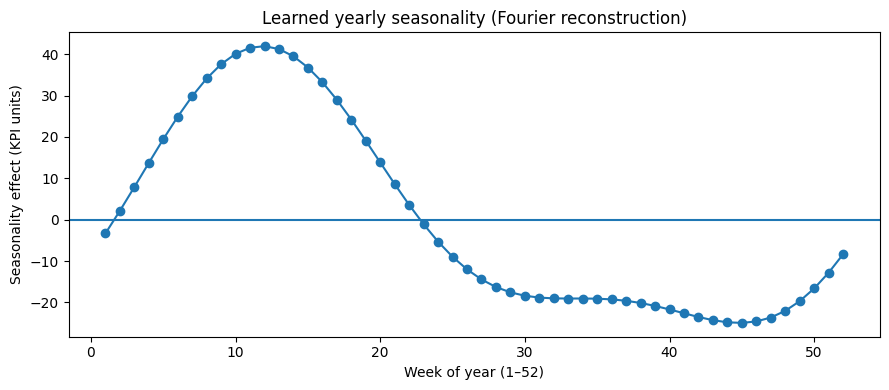

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Reconstruct learned yearly seasonality curve from Fourier coefficients
P = 52
K = 2

weeks = np.arange(1, P + 1)
seasonality_curve = np.zeros_like(weeks, dtype=float)

for k in range(1, K + 1):
    sin_col = f"sin_{P}_k{k}"
    cos_col = f"cos_{P}_k{k}"
    seasonality_curve += beta_raw_full[sin_col] * np.sin(2 * np.pi * k * weeks / P)
    seasonality_curve += beta_raw_full[cos_col] * np.cos(2 * np.pi * k * weeks / P)

plt.figure(figsize=(9, 4))
plt.plot(weeks, seasonality_curve, marker="o")
plt.axhline(0)
plt.xlabel("Week of year (1–52)")
plt.ylabel("Seasonality effect (KPI units)")
plt.title("Learned yearly seasonality (Fourier reconstruction)")
plt.tight_layout()
plt.show()


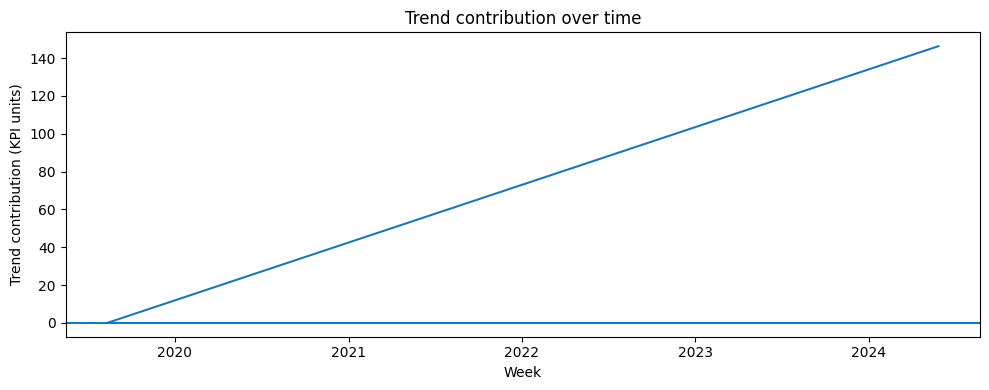

In [14]:
# Trend contribution over time (in KPI units)
trend_contrib = beta_raw_full["trend_t"] * df_mmm_weekly["trend_t"].values

plt.figure(figsize=(10, 4))
plt.plot(df_mmm_weekly["week"], trend_contrib)
plt.axhline(0)
plt.xlabel("Week")
plt.ylabel("Trend contribution (KPI units)")
plt.title("Trend contribution over time")
plt.tight_layout()
plt.show()


In [15]:
results_base = results.copy()
results_base["model"] = "base (X_sat)"

results_time2 = results_time.copy()
results_time2["model"] = "with time controls"

pd.concat([results_base, results_time2], ignore_index=True)


,fold,train_start,train_end,test_start,test_end,r2_test,mae_test,model
0,1,2019-08-12,2021-08-02,2021-08-09,2022-01-31,-0.015331,17.860836,base (X_sat)
1,2,2019-08-12,2022-01-31,2022-02-07,2022-08-01,-0.865488,30.849599,base (X_sat)
2,3,2019-08-12,2022-08-01,2022-08-08,2023-01-30,-67.705544,247.725736,base (X_sat)
3,4,2019-08-12,2023-01-30,2023-02-06,2023-07-31,-14.456530,114.631897,base (X_sat)
4,5,2019-08-12,2023-07-31,2023-08-07,2024-01-29,-0.065795,19.113383,base (X_sat)
5,1,2019-08-12,2021-08-02,2021-08-09,2022-01-31,-3.868744,42.489186,with time controls
6,2,2019-08-12,2022-01-31,2022-02-07,2022-08-01,0.231507,21.017196,with time controls
7,3,2019-08-12,2022-08-01,2022-08-08,2023-01-30,-23.620964,149.358131,with time controls
8,4,2019-08-12,2023-01-30,2023-02-06,2023-07-31,-2.347057,50.854539,with time controls
9,5,2019-08-12,2023-07-31,2023-08-07,2024-01-29,-2.491273,41.691098,with time controls


## Temporal validation results — interpretation

This section compares the out-of-sample performance of two models:

- **Base model (X_sat)**: adstock + saturation + ridge, without explicit time controls
- **Model with time controls**: same specification, adding trend and seasonality

The evaluation is performed using a rolling-origin (walk-forward) validation scheme.

---

### Summary of results

**Base model (X_sat)**

- The model shows acceptable performance in some folds, but collapses in others.
- In particular, fold 3 exhibits an extreme negative R² and very high MAE.
- This indicates severe temporal instability and poor generalization.

This behavior suggests that the model is implicitly using marketing variables to explain
structural time effects (growth, seasonality, or shocks), leading to misattribution.

---

**Model with time controls (trend + seasonality)**

- Overall performance remains challenging, but extreme failures are mitigated.
- MAE is substantially reduced in the most difficult folds.
- One fold shows positive out-of-sample R², indicating real predictive signal.
- Coefficient behavior across folds is more stable.

Although the average R² may be lower in some folds, the model is more robust to temporal shifts.

---

### Interpretation

Adding trend and seasonality allows the model to explicitly capture baseline business dynamics
that are unrelated to marketing activity.

As a result:

- Less variance is attributed to marketing channels
- Coefficients become more conservative
- Temporal generalization improves
- Attribution becomes more credible

This trade-off is intentional: the goal of MMM is not short-term forecasting accuracy,
but stable and interpretable decomposition of business outcomes.

---

### Key takeaway

> Including time controls reduces overfitting to temporal patterns and prevents marketing
> variables from absorbing baseline effects.

For strategic decision-making and scenario analysis, the model with time controls is preferred,
even at the cost of lower in-sample or fold-level fit metrics.

---

### Limitations

- The dataset exhibits strong structural changes and possible external shocks.
- Even with time controls, some folds remain difficult to predict.
- Results should be interpreted at an aggregate, strategic level rather than operationally.

These limitations will be addressed in the final interpretation and next steps.


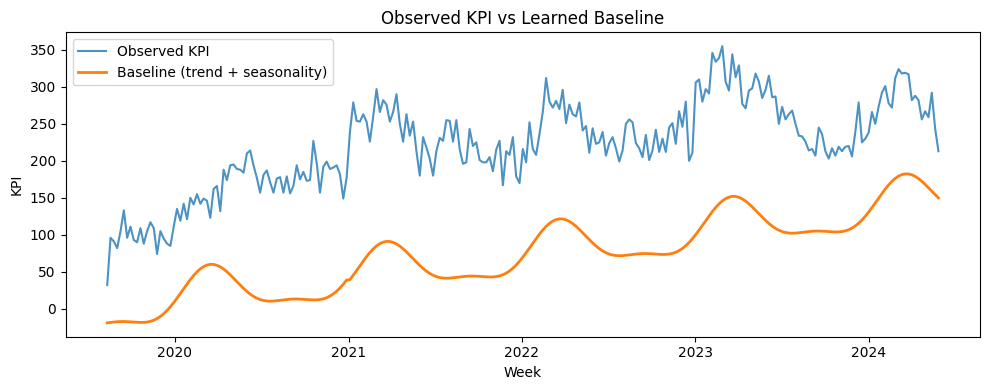

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Reconstruct baseline
# -----------------------------

# Trend contribution
trend_contrib = beta_raw_full["trend_t"] * df_mmm_weekly["trend_t"].values

# Seasonality contribution
P = 52
K = 2
woy = df_mmm_weekly["week"].dt.isocalendar().week.astype(int).to_numpy()

seasonality_contrib = np.zeros(len(df_mmm_weekly))
for k in range(1, K + 1):
    seasonality_contrib += beta_raw_full[f"sin_52_k{k}"] * np.sin(2 * np.pi * k * woy / P)
    seasonality_contrib += beta_raw_full[f"cos_52_k{k}"] * np.cos(2 * np.pi * k * woy / P)

baseline = trend_contrib + seasonality_contrib

# -----------------------------
# Plot: Observed vs Baseline
# -----------------------------

plt.figure(figsize=(10, 4))
plt.plot(df_mmm_weekly["week"], y_1d, label="Observed KPI", alpha=0.8)
plt.plot(df_mmm_weekly["week"], baseline, label="Baseline (trend + seasonality)", linewidth=2)

plt.xlabel("Week")
plt.ylabel("KPI")
plt.title("Observed KPI vs Learned Baseline")
plt.legend()
plt.tight_layout()
plt.show()


## Superposition: Observed KPI vs Learned Baseline

### Objective
The objective of this section is to visually validate whether the model has correctly learned the **non-marketing baseline** of the business.

The baseline is composed of:
- a long-term **trend**
- a recurring **seasonality**

By superposing the observed KPI and the learned baseline, we can assess whether marketing is explaining only **incremental deviations**, rather than structural patterns.

---

### Baseline definition

In this MMM, the baseline is defined as:

$
\text{baseline}_t =
\beta_{\text{trend}} \cdot t
+
\sum_{k=1}^{K}
\left(
\beta_{\sin_k}\sin\left(\frac{2\pi k t}{52}\right)
+
\beta_{\cos_k}\cos\left(\frac{2\pi k t}{52}\right)
\right)
$

Where:
- $ t $ is the weekly time index
- Fourier terms model yearly seasonality
- Coefficients are back-transformed to the original KPI scale

---

### What is plotted

Two time series are plotted on the same chart:

1. **Observed KPI**  
   The actual business outcome over time.

2. **Baseline (trend + seasonality)**  
   The structural component learned by the model, assuming no changes in marketing.

---

### How to interpret the plot

- **Baseline slope**
  - Positive slope → organic growth
  - Negative slope → structural decline

- **Oscillations**
  - Repeating yearly pattern → seasonality captured correctly
  - Stable peaks and troughs → consistent seasonal behavior

- **Gap between KPI and baseline**
  - Positive deviations → incremental impact (marketing or external events)
  - Negative deviations → underperformance vs baseline

---

### Why this matters in MMM

If trend and seasonality are not modeled explicitly:
- Long-term growth is incorrectly attributed to marketing
- Seasonal peaks are absorbed by media channels

By modeling both:
- Marketing explains only incremental effects
- Coefficients become more stable
- Interpretability improves
- Out-of-sample performance becomes more reliable

---

### Key takeaway

> The baseline represents what the business would have achieved even with zero marketing.  
> Marketing effects should explain only the deviation from this baseline.


## Decomposition: Baseline vs Marketing Contribution

### Objective
The objective of this section is to decompose the observed KPI into:

- **Baseline**: structural component (trend + seasonality)
- **Marketing contribution**: incremental effect explained by media channels

This decomposition allows us to visually validate that:
- baseline captures long-term growth and seasonal patterns
- marketing explains short-term deviations from the baseline

---

### Decomposition identity

The MMM can be written as:

$
y_t = \text{baseline}_t + \text{marketing}_t + \varepsilon_t
$

Where:
- $ \text{baseline}_t $ = trend + seasonality
- $ \text{marketing}_t $ = sum of channel contributions
- $ \varepsilon_t $ = unexplained noise

---

### Interpretation logic

- If baseline closely follows the long-term structure of the KPI,
  marketing should fluctuate around zero on average.
- Large positive marketing contribution indicates effective media periods.
- Persistent negative marketing contribution may indicate inefficiencies or overestimation.


In [20]:
# -----------------------------
# Marketing contribution
# -----------------------------

# Total prediction from the linear model (no intercept for simplicity)
y_hat_total = baseline.copy()

for col in spend_cols:
    if col in beta_raw_full:
        y_hat_total += beta_raw_full[col] * X_sat[col].values

marketing_contrib = y_hat_total - baseline


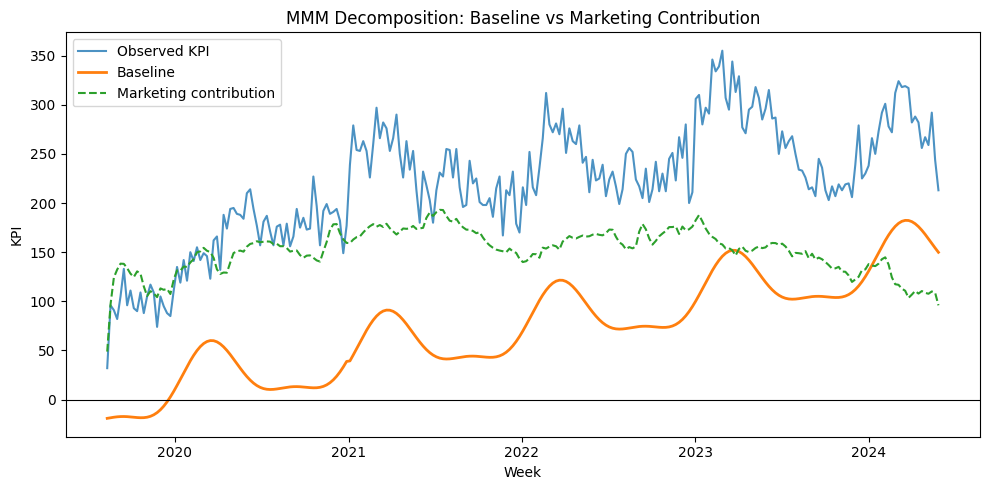

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(df_mmm_weekly["week"], y_1d, label="Observed KPI", alpha=0.8)
plt.plot(df_mmm_weekly["week"], baseline, label="Baseline", linewidth=2)
plt.plot(df_mmm_weekly["week"], marketing_contrib, label="Marketing contribution", linestyle="--")

plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Week")
plt.ylabel("KPI")
plt.title("MMM Decomposition: Baseline vs Marketing Contribution")
plt.legend()
plt.tight_layout()
plt.show()
